In [287]:
import requests
import json
import laspy
import os
import numpy as np
from pyproj.transformer import Transformer
from urllib.request import urlretrieve
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.windows import from_bounds
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
import shapely


def request_DEM_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, out_crs):
    file_name = temp_path + \
        f'out_crs EPSG {out_crs}, bbox {xmin}, {ymin}, {xmax}, {ymax} ' + \
        'DEM_merged.tif'

    if os.path.isfile(file_name):
        return file_name

    params = {
        'datasets':  'Digital Elevation Model (DEM) 1 meter',
        'bbox': f'{xmin},{ymin},{xmax},{ymax}'
    }

    r = requests.get(
        'https://tnmaccess.nationalmap.gov/api/v1/products?', params)

    map_urls = [item['downloadURL'] for item in r.json()['items']]

    print(map_urls[0])

    urlretrieve(map_urls[0], temp_path + map_urls[0].rpartition('/')[-1])

    with rasterio.open(temp_path + map_urls[0].rpartition('/')[-1]) as src:
        maps_crs = src.crs

    transformer = Transformer.from_crs("EPSG:4326", maps_crs)
    transformed_coords = transformer.transform([ymin, ymax], [xmin, xmax])

    xmin_t, ymin_t, xmax_t, ymax_t = transformed_coords[0][0], transformed_coords[
        1][0], transformed_coords[0][1], transformed_coords[1][1]

    elevation_arrays = []
    maps_to_merge = []
    src_bands = []
    for url in map_urls:
        urlretrieve(url, temp_path + url.rpartition('/')[-1])

    for url in map_urls:
        with rasterio.open(temp_path + url.rpartition('/')[-1]) as src:
            bbox = from_bounds(xmin_t, ymin_t, xmax_t, ymax_t, src.transform)
            elevation_array = src.read(1, window=bbox)
            elevation_arrays.append(elevation_array)
            meta_data = src.profile.data

            new_transform = rasterio.Affine(src.transform.a,
                                            src.transform.b,
                                            # translation in x
                                            max(src.bounds.left, xmin_t),
                                            src.transform.d,
                                            src.transform.e,
                                            # translation in y
                                            min(src.bounds.top, ymax_t))

            cropped_map = rasterio.open(temp_path + "cropped_" + url.rpartition('/')[-1], 'w', driver='GTiff',
                                        height=elevation_array.shape[0], width=elevation_array.shape[1],
                                        count=1, dtype=str(elevation_array.dtype),
                                        crs=src.crs,
                                        transform=new_transform)

            cropped_map.write(elevation_array, 1)
            cropped_map.close()

            cropped_map_read = rasterio.open(
                temp_path + "cropped_" + url.rpartition('/')[-1])
            maps_to_merge.append(cropped_map_read)

    mosaic, output = merge(maps_to_merge)

    output_meta = cropped_map.meta.copy()
    output_meta.update(
        {
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output,
            "crs": maps_crs
        })

    for map_to_merge in maps_to_merge:
        map_to_merge.close()

    with rasterio.open(file_name[:-3] + "temp.tif", "w", **output_meta) as m:
        m.write(mosaic)

    with rasterio.open(file_name[:-3] + "temp.tif") as src:
        transform, width, height = calculate_default_transform(
            src.crs, f"EPSG:{out_crs}", src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': f"EPSG:{out_crs}",
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(file_name, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=f"EPSG:{out_crs}",
                    resampling=Resampling.nearest)

    return file_name


def request_LiDAR_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, pointcloud_crs, out_crs):
    file_name = temp_path + \
        f'pc_crs EPSG {pointcloud_crs}, out_crs EPSG {out_crs}, bbox {
            xmin}, {ymin}, {xmax}, {ymax} ' + 'LiDAR_merged.las'

    if os.path.isfile(file_name):
        scan = laspy.read(file_name)
        return scan

    params = {
        'datasets':  'Lidar Point Cloud (LPC)',
        'bbox': f'{xmin}, {ymin}, {xmax}, {ymax}',
        'outputFormat': 'JSON'
    }

    r = requests.get(
        'https://tnmaccess.nationalmap.gov/api/v1/products?', params)

    if 'items' not in r.json().keys():
        return r.json()

    newest = max([item['publicationDate'] for item in r.json()['items']])

    lidar_urls = [item['downloadLazURL']
                  for item in r.json()['items'] if item['publicationDate'] == newest]

    # Save data locally
    for url in lidar_urls:
        if os.path.isfile(temp_path + url.rpartition('/')[-1]):
            continue
        else:
            urlretrieve(url, temp_path + url.rpartition('/')[-1])

    all_scan_points_arrays = []
    all_scan_xyzs = []

    transformer = Transformer.from_crs(
        "EPSG:4326",  f"EPSG:{out_crs}", always_xy=True)
    xmin_t, ymin_t = transformer.transform(xmin, ymin)
    xmax_t, ymax_t = transformer.transform(xmax, ymax)

    # Read all the scans
    for url in lidar_urls:
        scan = laspy.read(temp_path + url.rpartition('/')[-1])

        transformed_coords = (scan.xyz[:, 0], scan.xyz[:, 1], scan.xyz[:, 2])

        if pointcloud_crs != out_crs:
            # The EPGS code for NAD83(2011) / Conus Albers is 6350
            # The EPGS code for WGS84 is 4326
            transformer2 = Transformer.from_crs(
                f"EPSG:{pointcloud_crs}", f"EPSG:{out_crs}", always_xy=False)
            transformed_coords = transformer2.transform(
                scan.xyz[:, 0], scan.xyz[:, 1], scan.xyz[:, 2])

        # We now need to filter by world coordinates bounding box so we get
        # the points only for our area of interest. Lets inspect in what
        # coordinate system are the scans.

        mask = ((transformed_coords[0] > xmin_t) & (transformed_coords[0] < xmax_t) &
                (transformed_coords[1] > ymin_t) & (transformed_coords[1] < ymax_t))

        filtered_scan = scan[mask]

        filtered_scan.xyz[:, 0] = transformed_coords[0][mask]
        filtered_scan.xyz[:, 1] = transformed_coords[1][mask]
        filtered_scan.xyz[:, 2] = transformed_coords[2][mask]

        all_scan_xyzs.append(np.stack([transformed_coords[0][mask],
                                       transformed_coords[1][mask],
                                       transformed_coords[2][mask]], axis=1))

        all_scan_points_arrays.append(filtered_scan.points.array)

    # Merge into one dataset
    all_scan_points = np.concatenate(all_scan_points_arrays)
    all_scan_xyz = np.concatenate(all_scan_xyzs)

    scan = laspy.create(point_format=scan.header.point_format,
                        file_version=scan.header.version)
    scan.points.array = all_scan_points
    scan.xyz = all_scan_xyz
    scan.write(file_name)

    return scan


def request_FEMA_Footprint_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, out_crs):
    file_name = temp_path + \
        f'out_crs EPSG {out_crs}, bbox {xmin}, {ymin}, {xmax}, {ymax} ' + \
        'FEMA_buildings.json'
    if os.path.isfile(file_name):
        buildings = gpd.read_file(file_name)
        return buildings

    params = {
        'where': '',
        'objectIds':  '',
        'time':  '',
        'geometry': json.dumps({
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
            "spatialReference": {
                "wkid": 4326
            }
        }),
        'geometryType': 'esriGeometryEnvelope',
        'inSR':  '',
        'spatialRel': 'esriSpatialRelContains',
        'resultType': 'none',
        'distance': 0.0,
        'units': 'esriSRUnit_Meter',
        'relationParam':  '',
        'returnGeodetic': 'false',
        'outFields':  'OBJECTID, BUILD_ID, OCC_CLS, PRIM_OCC, SEC_OCC, PROP_ADDR, PROP_CITY, PROP_ST, PROP_ZIP, OUTBLDG, HEIGHT, SQMETERS, SQFEET, H_ADJ_ELEV, L_ADJ_ELEV, FIPS, CENSUSCODE, PROD_DATE, SOURCE, USNG, LONGITUDE, LATITUDE, IMAGE_NAME, IMAGE_DATE, VAL_METHOD, REMARKS, UUID, STATE_FIPS, Shape__Area, Shape__Length',
        'returnGeometry': 'true',
        'returnCentroid': 'false',
        'returnEnvelope': 'false',
        'featureEncoding': 'esriDefault',
        'multipatchOption': 'xyFootprint',
        'maxAllowableOffset':  '',
        'geometryPrecision':  '',
        'outSR':  json.dumps({"wkid": out_crs}),
        'defaultSR':  '',
        'datumTransformation':  '',
        'applyVCSProjection': 'false',
        'returnIdsOnly': 'false',
        'returnUniqueIdsOnly': 'false',
        'returnCountOnly': 'false',
        'returnExtentOnly': 'false',
        'returnQueryGeometry': 'true',
        'returnDistinctValues': 'true',
        'cacheHint': 'false',
        'orderByFields':  '',
        'groupByFieldsForStatistics':  '',
        'outStatistics':  '',
        'having':  '',
        'resultOffset':  '',
        'resultRecordCount':  '',
        'returnZ': 'true',
        'returnM': 'true',
        'returnExceededLimitFeatures': 'true',
        'quantizationParameters':  '',
        'sqlFormat': 'none',
        'f': 'pjson',
        'token':  ''
    }

    r = requests.get(
        'https://services2.arcgis.com/FiaPA4ga0iQKduv3/ArcGIS/rest/services/USA_Structures_View/FeatureServer/0/query?', params)

    with open(file_name, 'w', encoding='utf-8') as file:
        json.dump(r.json(), file)

    buildings = gpd.read_file(file_name)
    buildings = buildings.to_crs(out_crs)
    return buildings


def request_OSM_Footprint_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, out_crs):
    file_name = temp_path + \
        f'out_crs EPSG {out_crs}, bbox {xmin}, {ymin}, {xmax}, {ymax} ' + \
        'OSM_buildings.json'
    file_name_ = temp_path + \
        f'out_crs EPSG {out_crs}, bbox {xmin}, {ymin}, {xmax}, {ymax} ' + \
        'OSM_buildings_.json'
    if os.path.isfile(file_name):
        buildings = gpd.read_file(file_name)
        return buildings
    # tags = {"building": "yes"}

    # # left, bottom, right, top
    # bbox = xmin, ymin, xmax, ymax
    # r = ox.features.features_from_bbox(bbox=bbox, tags=tags)

    tags = {"building": True}
    r = ox.features.features_from_bbox(ymax, ymin, xmin, xmax, tags=tags)

    with open(file_name_, 'w', encoding='utf-8') as file:
        file.write(r.to_json())

    buildings = gpd.read_file(file_name_)
    bbox = gpd.GeoDataFrame({'geometry': [shapely.geometry.Polygon(
        [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)])]}, crs=buildings.crs)

    buildings = buildings.loc[buildings.geometry.type != "Point"].copy()

    buildings = buildings.sjoin(
        bbox.geometry.to_frame(), predicate="within"
    ).to_crs(out_crs).reset_index(drop=True)

    buildings.to_file(file_name)

    return buildings

In [178]:
out_crs = 26916
pointcloud_crs = 6350

xmin, ymin, xmax, ymax = -84.3824, 33.770, -84.3676, 33.7824
FEMA_footprints_file_name = f'FEMA_{xmin}, {ymin}, {xmax}, {ymax}_EPSG:{out_crs}.json'
OSM_footprints_file_name = f'OSM_{xmin}, {ymin}, {xmax}, {ymax}_EPSG:{out_crs}.json'
combined_footprints_file_name = f'combined_{xmin}, {ymin}, {xmax}, {ymax}_EPSG:{out_crs}.json'
lidar_footprints_file_name = f'lidar_{xmin}, {ymin}, {xmax}, {ymax}_EPSG:{out_crs}.json'


RC_file_name = f'RC_{xmin}, {ymin}, {xmax}, {ymax}_EPSG:{out_crs}.json'
temp_path = "./data/"


In [253]:
dem_path = request_DEM_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, out_crs)

In [288]:
FEMA_footprints = request_FEMA_Footprint_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, out_crs)
OSM_footprints = request_OSM_Footprint_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, out_crs)

C:\Users\steara\AppData\Local\Temp\ipykernel_26756\1190178951.py:304: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  r = ox.features.features_from_bbox(ymax, ymin, xmin, xmax, tags=tags)
C:\Users\steara\AppData\Local\Temp\ipykernel_26756\1190178951.py:304: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  r = ox.features.features_from_bbox(ymax, ymin, xmin, xmax, tags=tags)


In [279]:
scan = request_LiDAR_data_by_bbox(xmin, ymin, xmax, ymax, temp_path, pointcloud_crs, out_crs)

In [289]:
FEMA_footprints['residential'] = "Residential"

In [292]:
indices = list(FEMA_footprints.PRIM_OCC[FEMA_footprints.PRIM_OCC.isin([
 'Unclassified',
 'Colleges/Universities',
 'Medical Office/Clinic',
 'Personal and Repair Services',
 'General Services',
 'Professional/Technical Services',
 'Religious',
 'Entertainment and Recreation',
 'Other Educational Buildings',
 'Retail Trade',
 'Parking',
 'Pre-K - 12 Schools',
 'Nursing Home',
 'Emergency Response',
 'Community Center',
 'Light'])].index)

FEMA_footprints.iloc[indices, FEMA_footprints.columns.get_loc("residential")] = "Commercial"



In [293]:
FEMA_footprints.head()

,OBJECTID,BUILD_ID,OCC_CLS,PRIM_OCC,SEC_OCC,PROP_ADDR,PROP_CITY,PROP_ST,PROP_ZIP,OUTBLDG,...,IMAGE_NAME,IMAGE_DATE,VAL_METHOD,REMARKS,UUID,STATE_FIPS,Shape__Area,Shape__Length,geometry,residential
0,21442875,17231099,Residential,Multi - Family Dwelling,None,None,None,Georgia,None,None,...,Li218-Atlanta,1351209600000,Unverified,None,{b91adbe6-f0c6-40b4-97c4-c328d6688384},13,215.613281,58.939208,"POLYGON ((743200.685 3739771.974, 743200.654 3...",Residential
1,21442898,17231122,Commercial,Professional/Technical Services,None,None,None,Georgia,None,None,...,Li218-Atlanta,1351209600000,Unverified,None,{6696e053-fc5c-479c-9b11-f9e9428e2222},13,163.527344,53.178843,"POLYGON ((743212.668 3739759.358, 743204.629 3...",Commercial
2,21442905,17231129,Residential,Single Family Dwelling,None,None,None,Georgia,None,None,...,Li218-Atlanta,1351209600000,Unverified,None,{bffe96f1-f4dc-43ff-bd29-c1983063a819},13,267.933594,66.828257,"POLYGON ((743170.552 3739774.259, 743170.415 3...",Residential
3,21442939,17231163,Residential,Multi - Family Dwelling,None,None,None,Georgia,None,None,...,Li218-Atlanta,1351209600000,Unverified,None,{8a13de70-500e-42e8-9857-48d1082961a6},13,246.910156,70.625898,"POLYGON ((743185.214 3739776.846, 743185.064 3...",Residential
4,21442944,17231169,Residential,Multi - Family Dwelling,None,None,None,Georgia,None,None,...,Li218-Atlanta,1351209600000,Unverified,None,{6aff1c0f-93e0-4f88-8ba9-a2af8314bc39},13,220.597656,60.974337,"POLYGON ((743448.217 3739777.382, 743448.111 3...",Residential


In [298]:
OSM_nonresidential_indices = list(set(
    list(OSM_footprints.amenity[OSM_footprints.amenity.isna() == False].index) +
    list(OSM_footprints.tourism[OSM_footprints.tourism.isna() == False].index) +
    list(OSM_footprints.shop[OSM_footprints.shop.isna() == False].index) +
    list(OSM_footprints.cuisine[OSM_footprints.cuisine.isna() == False].index) +
    list(OSM_footprints.leisure[OSM_footprints.leisure.isna() == False].index) +
    list(OSM_footprints.sport[OSM_footprints.sport.isna() == False].index) +
    list(OSM_footprints.healthcare[OSM_footprints.healthcare.isna() == False].index) +
    list(OSM_footprints.building[OSM_footprints.building.isin(['apartments', 'church', 'commercial', 'construction',
         'hotel', 'office', 'parking', 'retail', 'roof', 'roof;yes', 'school', 'stadium', 'university'])].index)
))

OSM_footprints['residential'] = "Residential"
OSM_footprints.iloc[OSM_nonresidential_indices,
                    OSM_footprints.columns.get_loc("residential")] = "Commercial"

In [299]:
OSM_footprints.head()

,id,addr:housenumber,addr:state,amenity,building,ele,gnis:feature_id,name,source,website,...,wheelchair,area,construction,type,dispensing,healthcare,geometry,index_right,residential,61
0,"('way', 113802271)",None,None,None,yes,None,None,Midtown Promenade,None,None,...,None,None,None,None,None,None,"POLYGON ((743647.286 3740918.322, 743653.609 3...",0,Commercial,Commercial
1,"('way', 113921048)",906,None,None,yes,None,None,Sig Samuel's Dry Cleaning Company,None,None,...,None,None,None,None,None,None,"POLYGON ((743552.256 3740809.198, 743571.882 3...",0,Residential,NaN
2,"('way', 113921049)",900,None,restaurant,yes,None,None,La Hacienda Midtown,None,https://www.lahacienda-midtown.com/,...,None,None,None,None,None,None,"POLYGON ((743562.573 3740789.905, 743570.070 3...",0,Commercial,Commercial
3,"('way', 164559459)",417,None,None,yes,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((743199.946 3741026.539, 743209.392 3...",0,Residential,NaN
4,"('way', 164559460)",None,None,None,yes,None,None,None,None,None,...,None,None,None,None,None,None,"POLYGON ((743200.983 3740998.940, 743211.375 3...",0,Residential,NaN


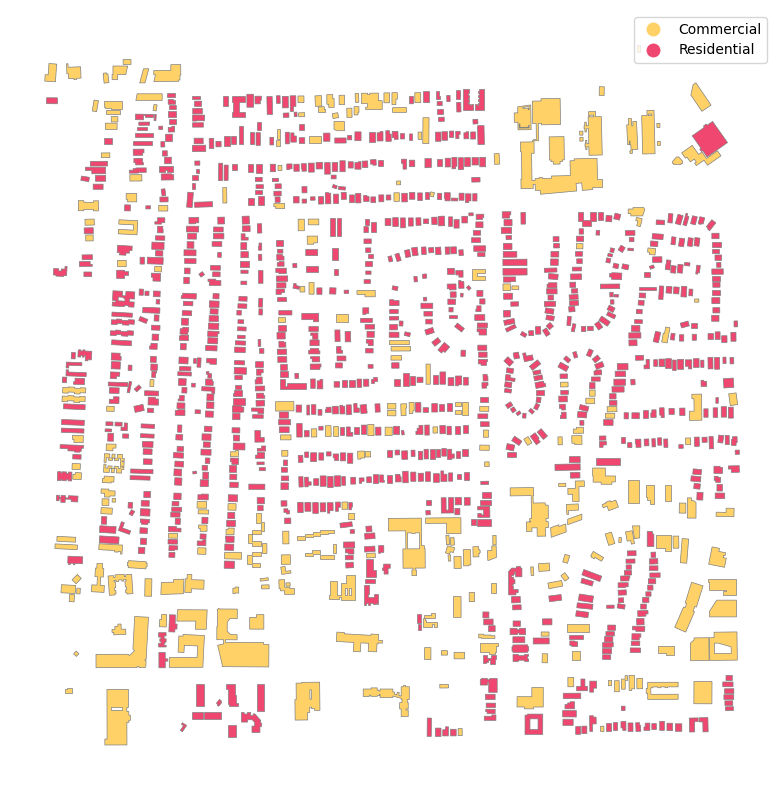

In [332]:
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(["#ffd166", "#ef476f"])

ax = FEMA_footprints.plot(column='residential',  cmap=newcmp, legend=True, figsize=(15, 10), edgecolor='grey', linewidth=0.5)
ax.set_axis_off()


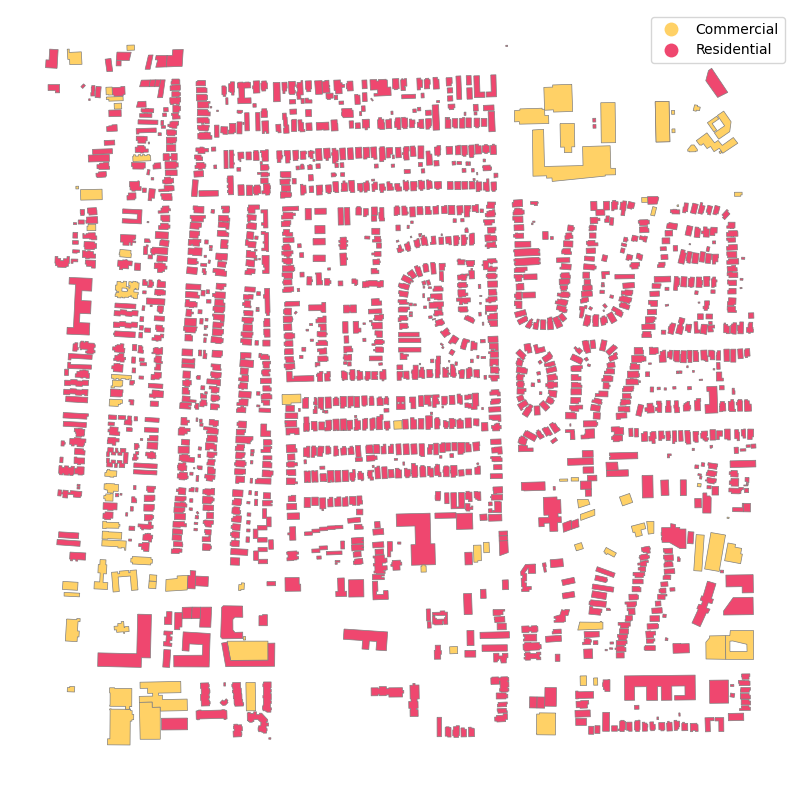

In [389]:
ax = OSM_footprints.plot(column='residential',  cmap=newcmp, legend=True, figsize=(15, 10), edgecolor='grey', linewidth=0.5)
ax.set_axis_off()

In [374]:
matched_indices = []
fema_indices = []
d_ind = {}
for i in range(FEMA_footprints.shape[0]):
    does_contain = FEMA_footprints.iloc[i].geometry.intersects(OSM_footprints.geometry)
    indices = does_contain.index[does_contain==True].tolist()
    if len(indices) == 0: continue
    d_ind[i] = indices
    matched_indices += indices
    fema_indices.append(i)

In [375]:
d_ind

{0: [798],
 1: [802],
 2: [785],
 3: [791],
 4: [823],
 5: [832],
 6: [827],
 7: [1185],
 8: [856],
 9: [846],
 10: [853],
 11: [844],
 12: [836],
 13: [841],
 14: [842],
 15: [838],
 16: [840],
 17: [851],
 18: [1205],
 19: [778],
 20: [1337],
 21: [1343],
 22: [830],
 23: [857],
 24: [858],
 25: [1301],
 26: [1187],
 27: [1187],
 28: [1269],
 29: [857, 859],
 30: [1352],
 31: [860],
 32: [1164],
 33: [1406],
 34: [1163],
 35: [1353],
 36: [861],
 37: [1317],
 38: [73, 1607, 1626],
 39: [1354],
 40: [1416],
 41: [94, 95, 96],
 42: [735, 748],
 44: [1534],
 45: [1188],
 46: [1300],
 47: [1609],
 49: [1355],
 50: [1341],
 51: [829],
 52: [1609],
 53: [1609],
 54: [99],
 55: [862],
 56: [1609],
 57: [113],
 58: [1609],
 59: [1356],
 60: [1609],
 61: [869],
 62: [863],
 63: [864],
 64: [98],
 65: [66],
 66: [100],
 67: [97],
 68: [787],
 69: [865],
 70: [866],
 71: [101],
 72: [847],
 73: [867],
 74: [1614],
 75: [1306],
 76: [870],
 77: [1179],
 78: [1218],
 79: [1604],
 80: [871],
 81: 

In [433]:
combined_footprints = FEMA_footprints.iloc[fema_indices]

vals = []
for key in d_ind:
    val = shapely.ops.unary_union(OSM_footprints.iloc[d_ind[key], OSM_footprints.columns.get_loc("geometry")].geometry)
    #combined_footprints.loc[key, combined_footprints.columns.get_loc("geometry")] = val
    vals.append(val)

combined_footprints["geometry"] = vals

d:\GATECH\HPBL\GNI\GitHub\env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


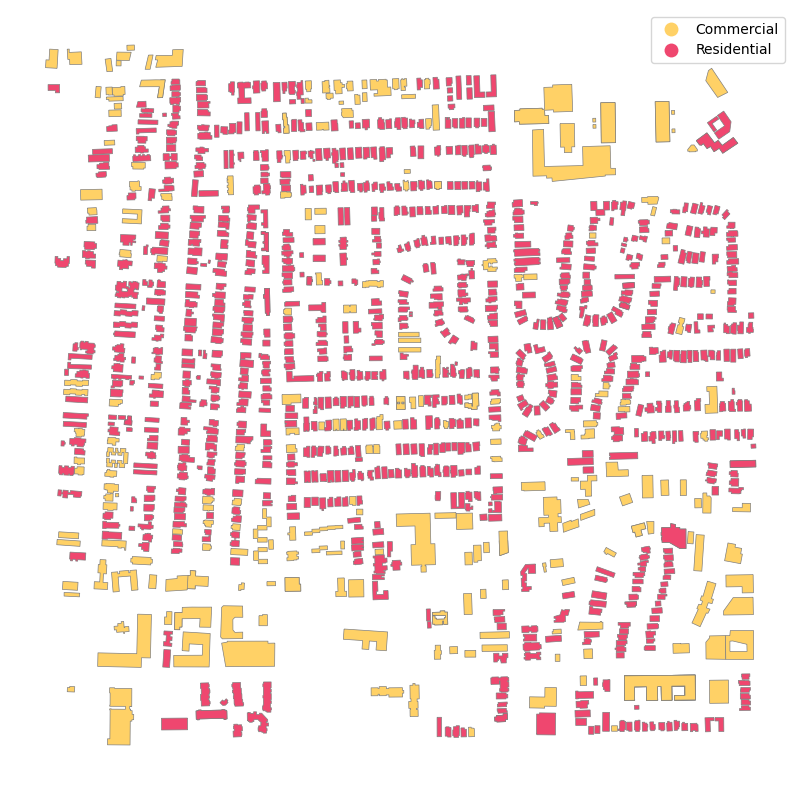

In [436]:
ax = combined_footprints.plot(column='residential',  cmap=newcmp, legend=True, figsize=(15, 10), edgecolor='grey', linewidth=0.5)
#FEMA_footprints.plot(column='residential',  ax=ax, legend=True, figsize=(15, 10), edgecolor='grey', linewidth=0.5)

ax.set_axis_off()

In [304]:
import pandas as pd
from sklearn.cluster import DBSCAN

def calculate_point_cloud_spacing_and_density(scan):
    points_to_calc = scan.points[#(scan.number_of_returns == 1) & 
                                  (scan.return_number == 1)]

    width =  np.max(points_to_calc.x) - np.min(points_to_calc.x)
    height = np.max(points_to_calc.y) - np.min(points_to_calc.y)

    bbox_area = width * height

    density =  points_to_calc.array.shape[0] / bbox_area
    spacing = 1.5 / np.sqrt(density)
    
    return spacing, density

def get_buiding_points(scan, out_crs):
    
    buildings = laspy.create(
        point_format=scan.header.point_format, 
        file_version=scan.header.version)

    points_to_calc = scan.points[#(scan.number_of_returns == 1) & 
                                (scan.return_number == 1)]

    width =  np.max(points_to_calc.x) - np.min(points_to_calc.x)
    height = np.max(points_to_calc.y) - np.min(points_to_calc.y)

    rt = scan.number_of_returns
    rt2 = scan.return_number
    over = scan.overlap
    bbox_area = width * height

    density =  points_to_calc.array.shape[0] / bbox_area
    spacing = 1.5 / np.sqrt(density)

    buildings.points = scan.points[(scan.classification == 6)]
    buildings_pts = np.stack([buildings.points.x, 
                            buildings.points.y, 
                            buildings.points.z], axis=1)


    buildings_scan_pts_gpd = gpd.points_from_xy(buildings_pts[:,0], buildings_pts[:,1])


    d = {'geometry': buildings_scan_pts_gpd}
    buildings_scan_pts_gpd = gpd.GeoDataFrame(d, crs=f"EPSG:{out_crs}")

    buildings_scan_pts_gpd['z'] = buildings_pts[:,2]


    return buildings_scan_pts_gpd

def intersect_building_points_with_footprints(buildings_scan_pts_gpd, footprints):
    points = np.stack([buildings_scan_pts_gpd.geometry.x, buildings_scan_pts_gpd.geometry.y], axis=1)

    mapped_points = {}

    global_inersect = None

    for i in range(footprints.shape[0]):

        footprint = footprints.iloc[i].geometry
        

        does_intersect = buildings_scan_pts_gpd.geometry.intersects(footprint)
        mapped_points[i] = buildings_scan_pts_gpd[does_intersect]

        if global_inersect is None:
            global_inersect = does_intersect
        else:
            global_inersect = np.logical_or(global_inersect, does_intersect)


    mapped_points_df = gpd.GeoDataFrame(pd.concat(mapped_points.values(), keys=mapped_points.keys(), axis=0))
    remaining_points_df = buildings_scan_pts_gpd[global_inersect == False]
    
    return mapped_points_df

def find_building_elevation(dem_path, footprints):
    elevations = []
    with rasterio.open(dem_path) as src:
        elev = src.read(1)
        
        for i in range(footprints.shape[0]):
            footprint = footprints.iloc[i].geometry

            rows, cols = rasterio.transform.rowcol(src.transform, footprint.centroid.x, footprint.centroid.y)

            rows = np.array(rows)
            cols = np.array(cols)
            rows[rows > elev.shape[0] - 1] = elev.shape[0] - 1
            cols[cols > elev.shape[1] - 1] = elev.shape[1] - 1
            
            z_coord = np.float64(elev[rows, cols])
            
            elevations.append(z_coord)

    return elevations
    
def extract_trees(scan, spacing):
    vegetation_types = [
        3,# Low Vegetation
        4,# Medium Vegetation
        5 # High Vegetation
    ]
    
    all_vegetation_clusters = []
    for i in vegetation_types:
        vegetation = laspy.create(point_format=scan.header.point_format, file_version=scan.header.version)
        vegetation.points = scan.points[(scan.classification == i)] 

        vegetation_pts = np.stack([vegetation.xyz[:,0],  
                                   vegetation.xyz[:,1], 
                                   vegetation.xyz[:,2]], axis=1)

                            
        vegetation_scan_pts_gpd = gpd.points_from_xy(vegetation_pts[:,0], vegetation_pts[:,1])


        d = {'geometry': vegetation_scan_pts_gpd}

        vegetation_scan_pts_gpd = gpd.GeoDataFrame(d, crs=f"EPSG:{out_crs}")

        vegetation_scan_pts_gpd['z'] = vegetation_pts[:,2]


        X = np.stack([vegetation_scan_pts_gpd.geometry.x, 
                      vegetation_scan_pts_gpd.geometry.y, 
                      vegetation_scan_pts_gpd['z']], axis=1)

        # eps - The maximum distance between two samples for one to be 
        # considered as in the neighborhood of the other.
        db = DBSCAN(eps=2 * spacing, min_samples=10).fit(X)
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print(f"Vegetation type {i} - Estimated number of clusters: {n_clusters_}")
        print(f"Vegetation type {i} - Estimated number of noise points: {n_noise_}")

        vegetation_clusters = []
        unique_labels = set(labels)

        for k in unique_labels:
            if k == -1:
                continue
            class_member_mask = labels == k
            if vegetation_scan_pts_gpd.iloc[class_member_mask].shape[0] < 120:
                continue
            cluster = np.stack([vegetation_scan_pts_gpd.iloc[class_member_mask].geometry.x,
                                vegetation_scan_pts_gpd.iloc[class_member_mask].geometry.y,
                                vegetation_scan_pts_gpd.iloc[class_member_mask].z], axis=1)

            vegetation_clusters.append(cluster)
        
        all_vegetation_clusters.append(vegetation_clusters)
        
    return(all_vegetation_clusters)

In [305]:
spacing, density = calculate_point_cloud_spacing_and_density(scan)

In [306]:
buildings_scan_pts_gpd = get_buiding_points(scan, out_crs)
buildings_scan_pts_gpd.head()

,geometry,z
0,POINT (742412.130 3740233.050),305.47
1,POINT (742412.230 3740232.450),305.75
2,POINT (742412.340 3740231.810),305.79
3,POINT (742412.450 3740231.100),305.51
4,POINT (742412.550 3740230.400),305.41


In [438]:
mapped_points_df = intersect_building_points_with_footprints(buildings_scan_pts_gpd, combined_footprints)
mapped_points_df.head()

geometry       z
0 1017420  POINT (743199.000 3739768.520)  313.49
  1017421  POINT (743199.030 3739769.180)  313.48
  1017422  POINT (743199.080 3739769.850)  313.42
  1017423  POINT (743199.120 3739770.520)  313.33
  1017424  POINT (743199.170 3739771.240)  313.05

In [439]:
combined_footprints["elevation"] = find_building_elevation(dem_path, combined_footprints)
combined_footprints.head().elevation

d:\GATECH\HPBL\GNI\GitHub\env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0    305.538391
1    305.757874
2    304.853668
3    305.234314
4    303.397339
Name: elevation, dtype: float64

In [440]:
combined_footprints["average_height"] = mapped_points_df.groupby(level=0)['z'].mean() - combined_footprints["elevation"]
combined_footprints.head()[["average_height","HEIGHT"]]

d:\GATECH\HPBL\GNI\GitHub\env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,average_height,HEIGHT
0,7.317583,7.32
1,7.454790,8.32
2,5.342386,6.27
3,5.815296,7.28
4,7.396309,7.11


In [441]:
combined_footprints["final_height"] = combined_footprints["average_height"].astype('float')
row_indexer = combined_footprints.index[combined_footprints["average_height"].isna()]

col_indexer_1 = combined_footprints.columns.get_loc("final_height")
col_indexer_2 = combined_footprints.columns.get_loc("HEIGHT")

combined_footprints.iloc[row_indexer, col_indexer_1] = combined_footprints.iloc[row_indexer, col_indexer_2].astype('float')

d:\GATECH\HPBL\GNI\GitHub\env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


IndexError: positional indexers are out-of-bounds

In [338]:
from matplotlib.ticker import PercentFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
from matplotlib.patches import Rectangle

def plot_heights_hist(heights_hist_title, heights, res):
    my_dpi = 150

    plasma = plt.get_cmap('plasma')

    font = {'fontname':'Roboto', 'size'   : 16}

    fmt = lambda x, pos: '{:.2f} %'.format(round(x * 100, 2))
    
    num_bins = 5
    if np.max(heights[res == "Residential"]) > 0:
        num_bins = 60
        
    scale_factor = 50
    if np.max(heights[res == "Residential"]) > 0:
        scale_factor = int(np.ceil(np.max(heights[res == "Commercial"])/np.max(heights[res == "Residential"])))

    fig = plt.figure(figsize=(900/my_dpi, 500/my_dpi), dpi=my_dpi)
    plt.box(False)
    plt.hist(heights[res == "Residential"], bins=num_bins, density = False, alpha=0.95, color='#ffd166')
    plt.hist(heights[res == "Commercial"], bins=num_bins*scale_factor, density = False, alpha=0.5, color='#ef476f')
    

    plt.hlines(y=0, xmin = np.min(heights), xmax=np.max(heights), colors='black')
    plt.xticks(np.arange(0, np.max(heights), step=5),  **font)
    plt.yticks(**font)

    plt.xlabel(heights_hist_title, **font)
    plt.ylabel("Number of buildings", **font)
    
    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k", linewidth=0.0, alpha=alpha) for c,alpha in zip(['#ffd166','#ef476f'],[0.95,0.5])]
    labels= ["Residential","Commercial"]
    L = plt.legend(handles, labels)
    plt.setp(L.texts, family='Roboto')
    
    plt.show() 
    return fig
    


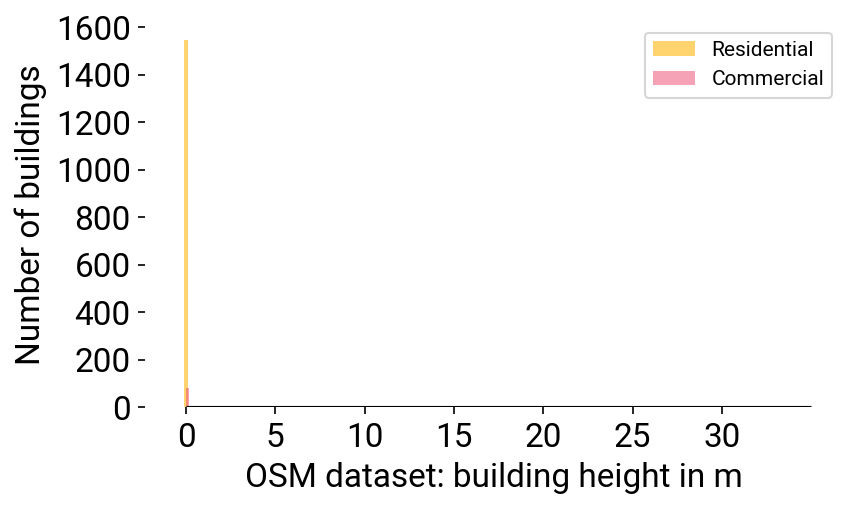

In [ ]:
OSM_heights_hist_filename = f'images/OSM_heights_hist.png'
OSM_heights_hist_title = "OSM dataset: building height in m"
OSM_heights = OSM_footprints.height.astype('float').fillna(0)

fig = plot_heights_hist(OSM_heights_hist_title, OSM_heights, OSM_footprints.residential)
fig.savefig(OSM_heights_hist_filename, bbox_inches='tight')


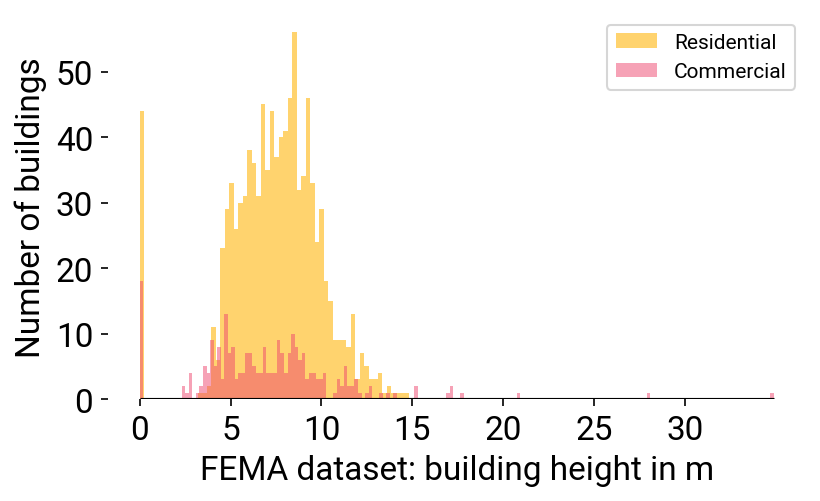

In [ ]:
FEMA_heights_hist_filename = f'images/FEMA_heights_hist.png'
FEMA_heights_hist_title = "FEMA dataset: building height in m"
FEMA_heights = FEMA_footprints.HEIGHT.astype('float').fillna(0)

fig = plot_heights_hist(FEMA_heights_hist_title, FEMA_heights, FEMA_footprints.residential)
fig.savefig(FEMA_heights_hist_filename, bbox_inches='tight')

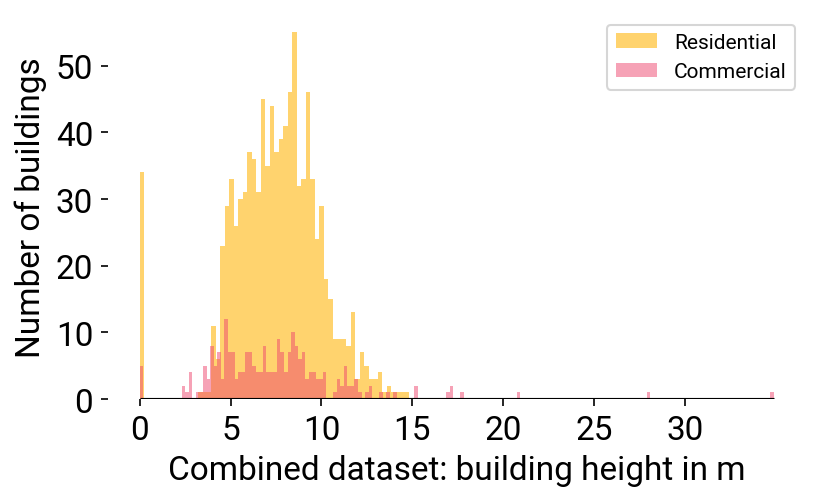

In [ ]:
combined_heights_hist_filename = f'images/combined_heights_hist.png'
combined_heights_hist_title = "Combined dataset: building height in m"
combined_heights = combined_footprints.HEIGHT.astype('float').fillna(0)

fig = plot_heights_hist(combined_heights_hist_title, combined_heights, combined_footprints.residential)
fig.savefig(combined_heights_hist_filename, bbox_inches='tight')


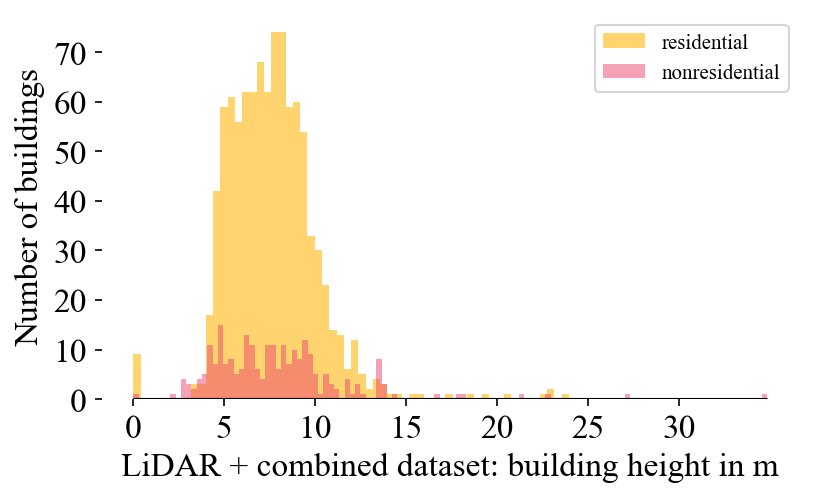

In [ ]:
lidar_heights_hist_filename = f'images/lidar_heights_hist.png'
lidar_heights_hist_title = "LiDAR + combined dataset: building height in m"
lidar_heights = combined_footprints.final_height.astype('float').fillna(0)

fig = plot_heights_hist(lidar_heights_hist_title, lidar_heights, combined_footprints.residential)
fig.savefig(lidar_heights_hist_filename, bbox_inches='tight')


In [142]:
combined_footprints.to_file(temp_path + \
        f'out_crs EPSG {out_crs}, bbox {xmin}, {ymin}, {xmax}, {ymax} ' + \
        'combined_buildings.json', driver='GeoJSON')



: 

In [ ]:
all_vegetation_clusters = extract_trees(scan, spacing)

Vegetation type 3 - Estimated number of clusters: 59
Vegetation type 3 - Estimated number of noise points: 552
Vegetation type 4 - Estimated number of clusters: 75
Vegetation type 4 - Estimated number of noise points: 543
Vegetation type 5 - Estimated number of clusters: 57
Vegetation type 5 - Estimated number of noise points: 781


In [ ]:
all_vegetation_clusters[0][0].shape

(140, 3)

In [72]:
from CGAL import CGAL_Alpha_wrap_3
from CGAL.CGAL_Polyhedron_3 import Polyhedron_3
from CGAL.CGAL_Kernel import Point_3
from CGAL.CGAL_Point_set_3 import Point_set_3
from CGAL.CGAL_Shape_detection import *
from CGAL.CGAL_Point_set_processing_3 import *
from CGAL.CGAL_Advancing_front_surface_reconstruction import *


def alphawrap_trees(clusters, spacing):
    meshes = []

    for cluster in clusters:
        for points in cluster:
            if points.shape[0] < 30: 
                meshes.append([])
                continue
            points_set = Point_set_3()
            # Insertions
            for i in range(points.shape[0]):
                 idx = points_set.insert(Point_3(points[i,0], points[i,1], points[i,2]))
            Q = Polyhedron_3()      
            # # # test with a point set as input
            CGAL_Alpha_wrap_3.alpha_wrap_3(list(points_set.points()), spacing*1.2, 0.1, Q)   
            
            meshes.append(Q)   

    return meshes


In [ ]:
tree_meshes = alphawrap_trees(all_vegetation_clusters, spacing)